In [11]:
import warnings
warnings.filterwarnings("ignore")
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import pandas as pd
import muon as mu
import scirpy as ir
np.random.seed(42)
import random
random.seed(42)

import functions.mdata_utils as mdata_utils


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/software/rhel9/manual/install/python/ondemand-jupyter-python3.11-2023.09/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/software/rhel9/manual/install/python/ondemand-jupyter-python3.11-2023.09/lib/python3.11/site-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/software/rhel9/manual/install/python/o

AttributeError: _ARRAY_API not found

2025-08-28 20:14:34.471869: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-28 20:14:34.603702: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756426474.619539 3745358 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756426474.624167 3745358 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1756426474.636602 3745358 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [6]:
import tensorflow as tf
tf.__version__

'2.19.0'

## load mdata

In [2]:
# mdata = mu.read("all_Common_DEtop2000.h5mu")
# mdata

In [3]:
mdata = mu.read("/ix1/ylee/Yifan_Zhang/Code_data/data_EAE/anndata/all_Common.h5mu")

prefixes_to_remove = ('CMO', 'ENSM', 'mt-'
                      'Trav', 'Traj', 'Trac', 'Trbv', 'Trbj', 
                     'Trbc', 'Trdv', 'Trdj', 'Trdc', 'Trgv', 'Trgj', 'Trgc') 

TCR_gene_mask = mdata.var_names.str.startswith(prefixes_to_remove)
mdata = mdata[:, ~TCR_gene_mask]

mdata['gex'].var_names_make_unique()

sc.pp.normalize_total(mdata['gex'])
sc.pp.log1p(mdata['gex'])

ir.pp.index_chains(mdata)
ir.tl.chain_qc(mdata)

# by nucleotide acid seq
ir.pp.ir_dist(mdata)
ir.tl.define_clonotypes(mdata, receptor_arms="all", dual_ir="primary_only")
# ir.tl.clonotype_network(mdata, min_cells=10)

meta_airr = ir.get.airr(mdata['airr'], ["cdr3_aa", "v_call", "j_call"] ,  ('VJ_1', 'VDJ_1'))
mdata.obs = mdata.obs.join(meta_airr)
mdata.update()

mdata

MuData object with n_obs × n_vars = 77660 × 33312
  obs:	'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'HTO_classification.global', 'hash.ID', 'percent.mt', 'integrated_nn_res.2', 'seurat_clusters', 'level_2_clusters', 'manual_cell_type', 'run_num', 'sample', 'VJ_1_cdr3_aa', 'VJ_1_v_call', 'VJ_1_j_call', 'VDJ_1_cdr3_aa', 'VDJ_1_v_call', 'VDJ_1_j_call'
  2 modalities
    gex:	77660 x 33312
      obs:	'mouse_id', 'date', 'tissue', 'sample', 'mouse_BC'
      uns:	'log1p'
    airr:	77660 x 0
      obs:	'receptor_type', 'receptor_subtype', 'chain_pairing', 'clone_id', 'clone_id_size'
      uns:	'chain_indices', 'ir_dist_nt_identity', 'clone_id'
      obsm:	'airr', 'chain_indices'

## QC

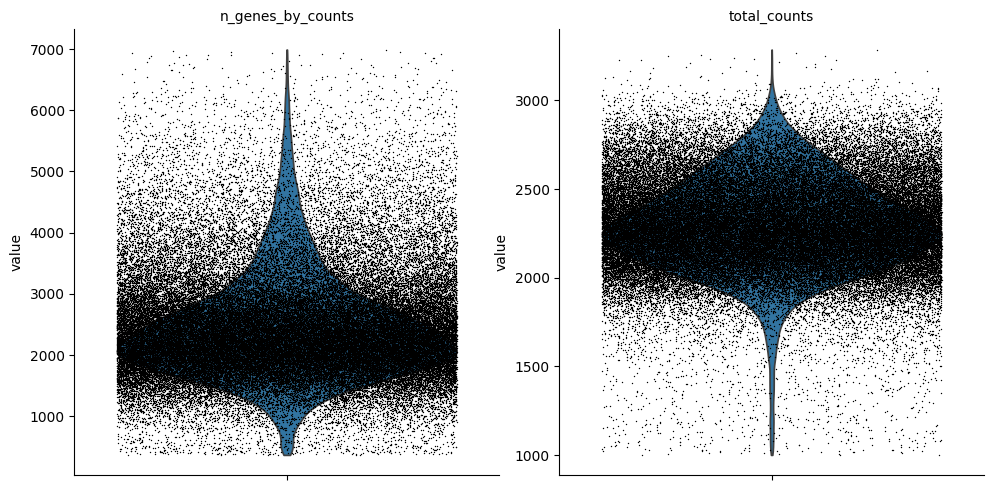

In [4]:
mdata['gex'].var["mt"] = mdata['gex'].var_names.str.startswith("mt-")
# ribosomal genes
mdata['gex'].var["ribo"] = mdata['gex'].var_names.str.startswith(("Rps", "Rpl"))
# hemoglobin genes
mdata['gex'].var["hb"] = mdata['gex'].var_names.str.contains("^Hb[^(p)]")

sc.pp.calculate_qc_metrics(
    mdata['gex'], qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
)

sc.pp.filter_cells(mdata['gex'], min_genes= 300)
sc.pp.filter_cells(mdata['gex'], max_genes= 7000)

sc.pp.filter_cells(mdata['gex'], min_counts=1000)
sc.pp.filter_cells(mdata['gex'], max_counts=40000)

sc.pp.filter_genes(mdata['gex'], min_cells=50)

sc.pl.violin(
    mdata['gex'],
    ["n_genes_by_counts", "total_counts"],
    jitter=0.4,
    multi_panel=True,
)

In [5]:
sc.pp.highly_variable_genes(mdata['gex'], n_top_genes=2500, batch_key="mouse_id")
mdata.mod['gex'] = mdata['gex'][:, mdata['gex'].var['highly_variable']].copy()

In [6]:
mdata = mdata_utils.sync_mdata_obs(mdata)
mdata

MuData object with n_obs × n_vars = 77502 × 2500
  obs:	'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'HTO_classification.global', 'hash.ID', 'percent.mt', 'integrated_nn_res.2', 'seurat_clusters', 'level_2_clusters', 'manual_cell_type', 'run_num', 'sample', 'VJ_1_cdr3_aa', 'VJ_1_v_call', 'VJ_1_j_call', 'VDJ_1_cdr3_aa', 'VDJ_1_v_call', 'VDJ_1_j_call'
  2 modalities
    gex:	77502 x 2500
      obs:	'mouse_id', 'date', 'tissue', 'sample', 'mouse_BC', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'n_counts'
      var:	'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
      uns:	'log1p', 'hvg'
    airr:	77502 x 0
      obs:	'receptor_type', 'receptor_subtype', 'chain_pairing', 'clone_id', 'clone_id_size'
      uns:	'chain_indices', 'ir_dist_nt_identity', 'clone_id'
      obsm:	'airr', 'chain_indices'

## Annotation

In [7]:
sc.pp.pca(mdata["gex"], svd_solver="arpack", n_comps=50)
sc.pp.neighbors(mdata["gex"], n_neighbors = 50)
sc.tl.umap(mdata["gex"], min_dist=0.5, spread=1.0)

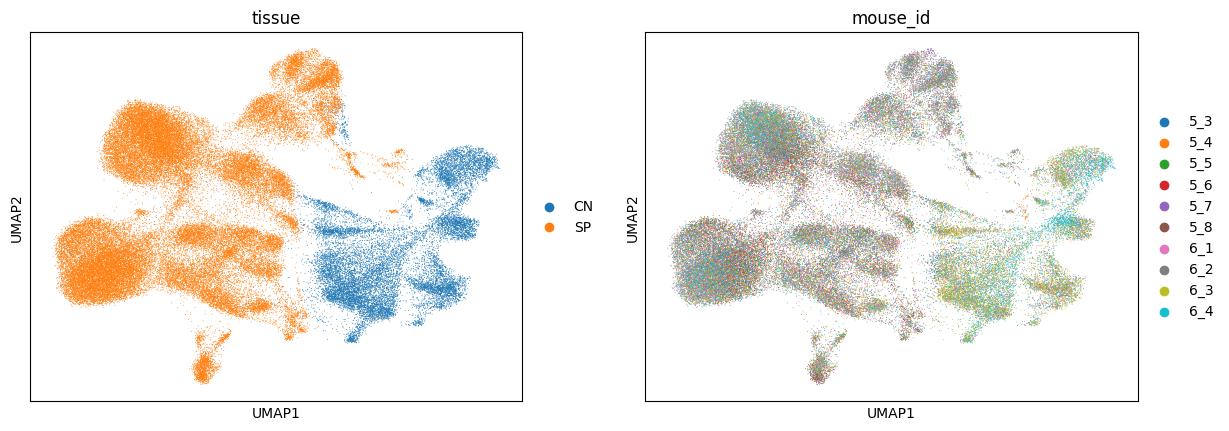

In [8]:
sc.tl.leiden(mdata["gex"], resolution = 1, n_iterations=-1, flavor = 'igraph')
sc.pl.umap(mdata["gex"], color=["tissue", "mouse_id"])

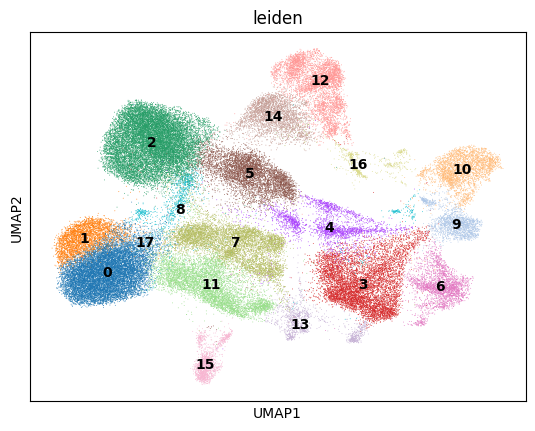

In [9]:
sc.pl.umap(mdata["gex"], color="leiden", legend_loc="on data")

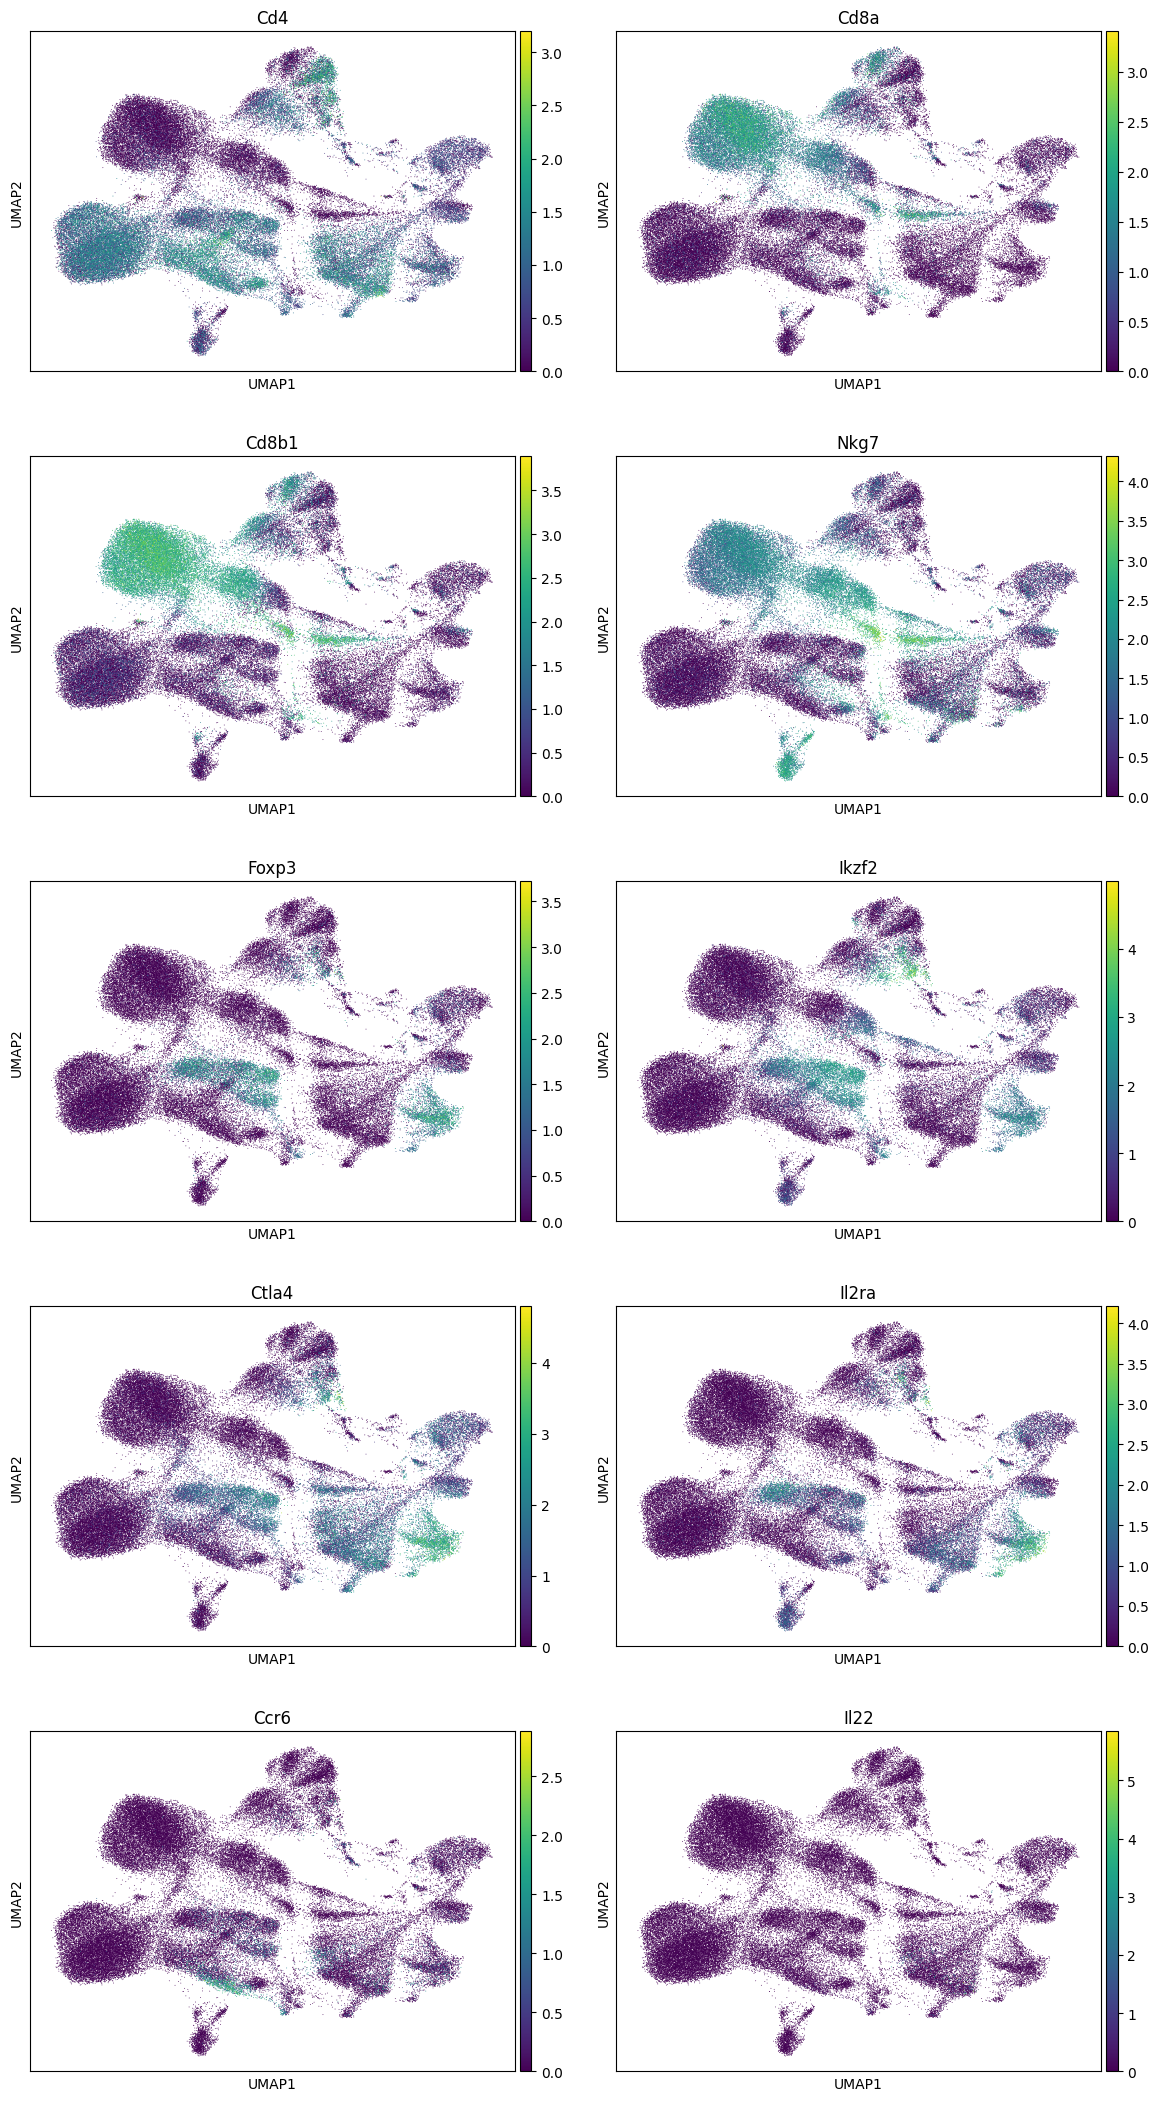

In [10]:
type_markers = ['Cd4', 'Cd8a','Cd8b1','Nkg7','Foxp3', 'Ikzf2', 'Ctla4', 'Il2ra','Ccr6', 'Il22']
state_markers = ['Isg15', 'Gbp2', 'Ifih1', 'Icos', 'Cd69', 'Cd28', 'Pdcd1', 'Lag3', 'Havcr2', 'Ccr7', 'Sell', 'Cd27']
myloid_markers = ['Cd11b', 'Cd33', 'Cd45', 'Cd68']
markers_in = []

for i in type_markers:
    if i in mdata["gex"].var_names:
        markers_in.append(i) 
        
mu.pl.embedding(mdata["gex"], basis="umap", color= markers_in,  wspace = 0.1, ncols=2, vmin=0)

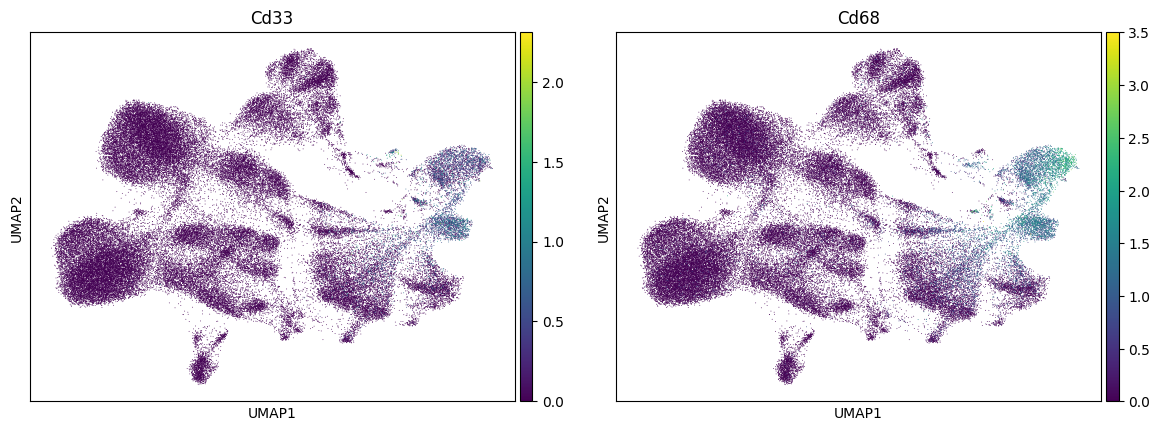

In [11]:
myloid_markers = ['Cd11b', 'Cd33', 'Cd45', 'Cd68']
markers_in = []

for i in myloid_markers:
    if i in mdata["gex"].var_names:
        markers_in.append(i) 
        
mu.pl.embedding(mdata["gex"], basis="umap", color= markers_in,  wspace = 0.1, ncols=2, vmin=0)

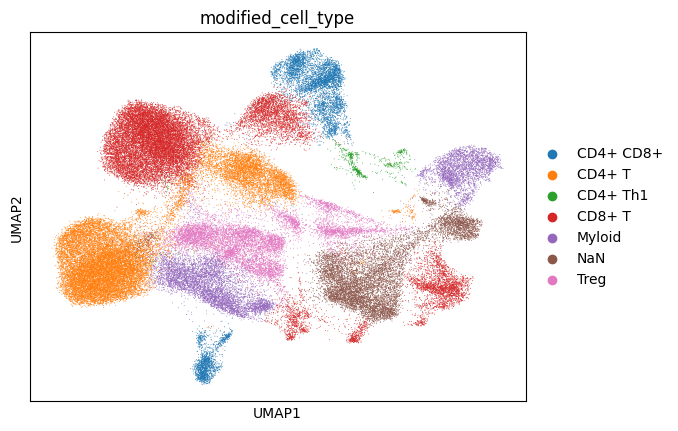

In [12]:
mdata["gex"].obs['modified_cell_type'] = 'NaN'
mdata["gex"].obs['modified_cell_type'][mdata["gex"].obs['leiden'].isin(['2','13','6','14',])] = 'CD8+ T'
mdata["gex"].obs['modified_cell_type'][mdata["gex"].obs['leiden'].isin(['4','7'])] = 'Treg'
mdata["gex"].obs['modified_cell_type'][mdata["gex"].obs['leiden'].isin(['8'])] = 'CD4+ Th17'
mdata["gex"].obs['modified_cell_type'][mdata["gex"].obs['leiden'].isin(['16'])] = 'CD4+ Th1'
mdata["gex"].obs['modified_cell_type'][mdata["gex"].obs['leiden'].isin(['5','1','0','18','8'])] = 'CD4+ T'
mdata["gex"].obs['modified_cell_type'][mdata["gex"].obs['leiden'].isin(['10','11'])] = 'Myloid'

mdata["gex"].obs['modified_cell_type'][mdata["gex"].obs['leiden'].isin(['12','15'])] = 'CD4+ CD8+'

sc.pl.umap(mdata["gex"], color=['modified_cell_type'])

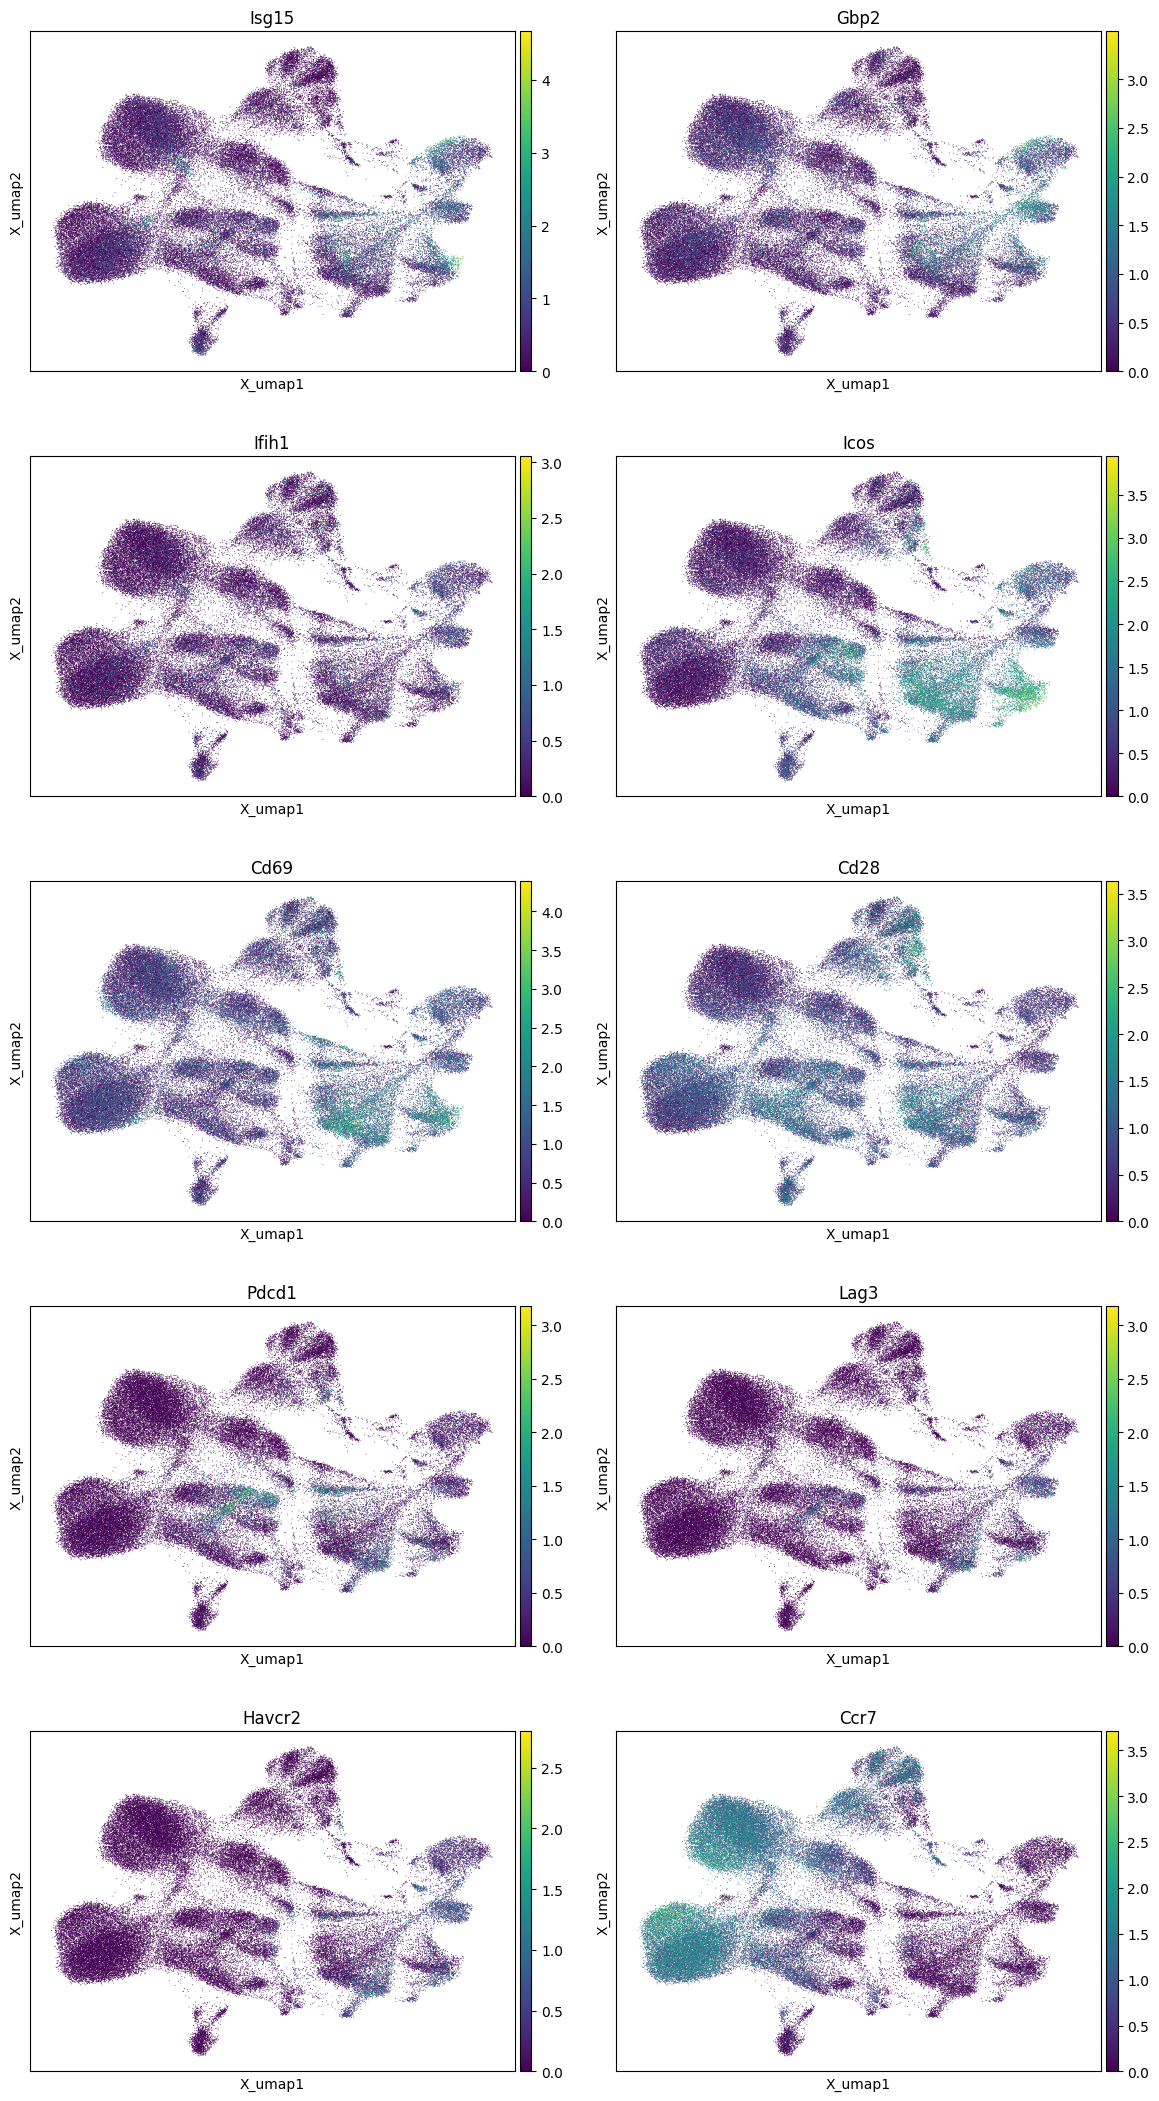

In [13]:
markers_in = []
for i in state_markers:
    if i in mdata["gex"].var_names:
        markers_in.append(i) 
mu.pl.embedding(mdata, basis="gex:umap", color= markers_in, wspace = 0.1, ncols=2, vmin=0)

In [14]:
import scanpy as sc

IFN_stim = ['Isg15', 'Gbp2', 'Ifih1']
Activation = ['Icos', 'Cd69', 'Cd28']
Exhaust = ['Pdcd1', 'Lag3', 'Havcr2']
Mem = ['Ccr7', 'Sell', 'Cd27']

sc.tl.score_genes(mdata['gex'], gene_list=IFN_stim, score_name='IFN_stim')
sc.tl.score_genes(mdata['gex'], gene_list=Activation, score_name='Activation')
sc.tl.score_genes(mdata['gex'], gene_list=Exhaust, score_name='Exhaust')
sc.tl.score_genes(mdata['gex'], gene_list=Mem, score_name='Mem')

In [15]:
mdata['gex'].obs['state'] = 'Effector'
mdata['gex'].obs.loc[mdata['gex'].obs['Exhaust'] > 0.5, 'state'] = 'Exhausted'
mdata['gex'].obs.loc[mdata['gex'].obs['Mem'] > 0.5, 'state'] = 'Mem'
mdata['gex'].obs.loc[mdata['gex'].obs['IFN_stim'] > 0.5, 'state'] = 'activated'
mdata['gex'].obs.loc[mdata['gex'].obs['Activation'] > 0.5, 'state'] = 'activated'


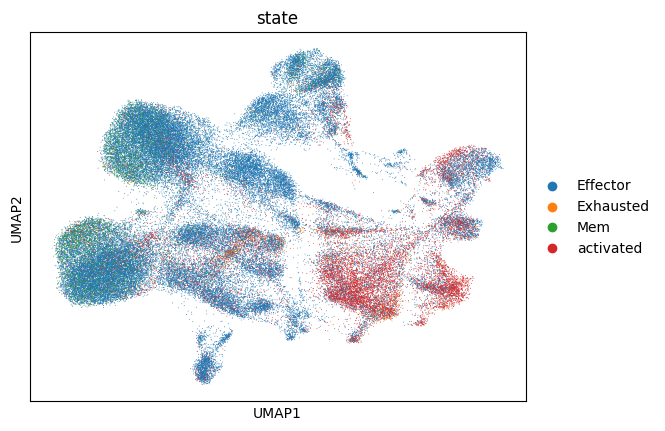

In [16]:
sc.pl.umap(mdata["gex"], color=['state'])

## MOG and 2D2 difference

### subclusters

In [17]:
Treg2D2_idx = (mdata['gex'].obs['mouse_id'].astype('str').isin(['5_3','5_4']))
mdata_2D2 = mdata[Treg2D2_idx.astype('bool')]
mdata_MOG = mdata[~Treg2D2_idx.astype('bool')]

mdata['gex'].obs['is_2D2'] = Treg2D2_idx

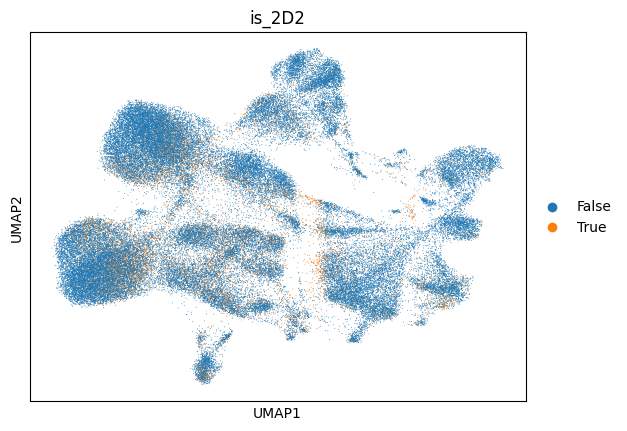

In [18]:
sc.pl.umap(mdata["gex"], color=['is_2D2'])

In [19]:
### single gene distribution
from scipy.stats import ranksums

for type_i in ['CD4+ T', 'CD8+ T', 'Treg']:
    expr_A = mdata_2D2['gex'][mdata_2D2['gex'].obs['modified_cell_type']== type_i][:, 'Cd4'].X.toarray().flatten()
    expr_B = mdata_MOG['gex'][mdata_MOG['gex'].obs['modified_cell_type']== type_i][:, 'Cd4'].X.toarray().flatten()
    stat, pval = ranksums(expr_A, expr_B)
    print("Wilcoxon rank-sum p-value:", pval)


Wilcoxon rank-sum p-value: 1.725177119179581e-12
Wilcoxon rank-sum p-value: 2.790858043707176e-07
Wilcoxon rank-sum p-value: 7.045283722881664e-11


### Correlations of pseudobulk expression values

In [27]:
import pandas as pd
from scipy.sparse import issparse
import numpy as np

def to_dense(X):
    if issparse(X):
        return X.toarray()
    return X

def clusters_corr(adata1, adata2):
    common = adata1.var_names.intersection(adata2.var_names)
    a1 = adata1[:, common]
    a2 = adata2[:, common]

    pb1 = to_dense(a1.X).mean(axis=0)
    pb2 = to_dense(a2.X).mean(axis=0)

    df = pd.DataFrame({"group1": pb1, "group2": pb2}, index=common)

    corr_pearson = df["group1"].corr(df["group2"], method="pearson")
    corr_spearman = df["group1"].corr(df["group2"], method="spearman")
    return corr_pearson, corr_spearman

pearson = []
spearman = []
for row_idx, cat1 in enumerate(mdata['gex'].obs['mouse_id'].unique()):
    for col_idx, cat2 in enumerate(mdata['gex'].obs['mouse_id'].unique()):
        if row_idx == col_idx:
            pearson.append(1)
            spearman.append(1)
        else:
            adata1 = mdata['gex'][mdata['gex'].obs['mouse_id']== cat1]
            adata2 = mdata['gex'][mdata['gex'].obs['mouse_id']== cat2]
            stat, pval = clusters_corr(adata1, adata2)
            pearson.append(pval)
            spearman.append(stat)
        
spearman_df = np.array(spearman).reshape([row_idx+1,col_idx+1])

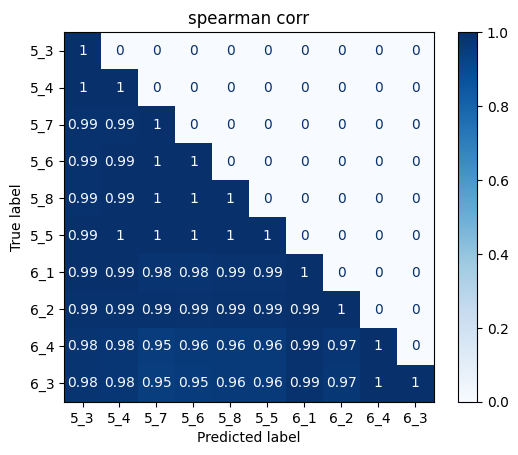

In [29]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

disp = ConfusionMatrixDisplay(confusion_matrix= np.tril(spearman_df), display_labels = mdata['gex'].obs['mouse_id'].unique())
disp.plot(cmap='Blues')
plt.title('spearman corr')
plt.show()

In [ ]:
# pip install scikit-bio
aa

import numpy as np
import pandas as pd
from scipy.sparse import issparse
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist, squareform
from skbio import DistanceMatrix
from skbio.stats.distance import permanova

In [ ]:
# -------------------------
# 1) Prepare: intersect genes and align
# -------------------------
def intersect_align_genes(a1, a2):
    common = a1.var_names.intersection(a2.var_names)
    a1 = a1[:, common].copy()
    a2 = a2[:, common].copy()
    return a1, a2

# compare between 2D2 mouse
# adata1 = mdata_2D2['gex'][mdata_2D2['gex'].obs['mouse_id']=='5_3']
# adata2 = mdata_2D2['gex'][mdata_2D2['gex'].obs['mouse_id']=='5_4']

# adata1 = mdata_2D2['gex']
# adata2 = mdata_MOG['gex']


adata1, adata2 = intersect_align_genes(adata1, adata2)

# -------------------------
# 2) Pseudobulk per biological replicate
#    - change 'sample' below to your replicate key (e.g., 'donor', 'batch')
#    - method='mean' is common; for counts, you might prefer 'sum'
# -------------------------
def pseudobulk(adata, by='sample', layer=None, method='mean'):
    mat = adata.layers[layer] if layer is not None else adata.X
    if issparse(mat):
        mat = mat.toarray()
    df = pd.DataFrame(mat, index=adata.obs[by].values, columns=adata.var_names)
    if method == 'mean':
        return df.groupby(level=0).mean()
    elif method == 'sum':
        return df.groupby(level=0).sum()
    else:
        raise ValueError("method must be 'mean' or 'sum'")

# Example: use log-normalized expression in .X.
# If you have raw counts in a layer (e.g., 'counts'), set layer='counts' and method='sum'.
pb1 = pseudobulk(adata1, by='mouse_id', layer=None, method='mean')
pb2 = pseudobulk(adata2, by='mouse_id', layer=None, method='mean')

# -------------------------
# 3) Build the sample × gene matrix and group labels
# -------------------------
X = pd.concat([pb1, pb2], axis=0)
groups = pd.Series(
    (['group1'] * pb1.shape[0]) + (['group2'] * pb2.shape[0]),
    index=X.index, name='group'
)

# Sanity check: need ≥2 samples total and ideally ≥2 per group
print(groups.value_counts())

# -------------------------
# 4) Scale features, compute distances, run PERMANOVA
# -------------------------
X_scaled = StandardScaler(with_mean=True, with_std=True).fit_transform(X.values)
D = squareform(pdist(X_scaled, metric="euclidean"))  # try "braycurtis" for compositional data
dm = DistanceMatrix(D, ids=X.index)

meta = pd.DataFrame({'group': groups})
res = permanova(distance_matrix=dm, grouping=meta['group'], permutations=999)
print(res)

## cluster DEA with decoupleR

In [ ]:
import decoupler as dc
dc.__version__

In [ ]:
aa
collectri = dc.op.collectri(organism="mouse")
ri_merged = collectri.groupby('source').agg({
    'weight': 'mean',         # average of numbers
    'target': lambda x: '|'.join(x)  # join with |
}).reset_index()

ri_merged

In [ ]:
# combined = df.groupby('col1')['col2'].sum()
# combined

In [ ]:
dc.mt.ulm(data=mdata['gex'], net=collectri)
score = dc.pp.get_obsm(adata=mdata['gex'], key="score_ulm")

In [ ]:
score.obsm['score_ulm']

In [ ]:
tf = "Ar"
sc.pl.umap(score, color=[tf, "modified_cell_type"], cmap="RdBu_r", vcenter=0, title=[f"{tf} score", "celltype"])

## Scirpy EDA

In [ ]:
ir.pp.ir_dist(
    mdata,
    metric="tcrdist",
    sequence="aa",
    cutoff=15,
)

ir.tl.define_clonotype_clusters(mdata, sequence="aa", metric="tcrdist", receptor_arms="all", dual_ir="any")
ir.tl.clonotype_network(mdata, min_cells=10, sequence="aa", metric="tcrdist")
_ = ir.pl.clonotype_network(mdata, color="sample", label_fontsize=9, panel_size=(8,8), base_size=20)


In [ ]:
# Perform clonal expansion analysis
ir.tl.clonal_expansion(mdata)

mdata.obs["celltype_sample"] = (
    mdata['gex'].obs["modified_cell_type"].astype(str) + "_" + mdata.obs["sample"].astype(str)
)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
_ = ir.pl.clonal_expansion(
    mdata, 
    target_col="clone_id",
    groupby="celltype_sample",  # Use the new combined column
    breakpoints=(1, 2, 5), 
    ax = ax
    #normalize=False
)

## clonotype dist

In [ ]:
# select cells appear in both CNS and SPL

# thresh on clono size
clone_thresh = 2
mdata.obs['cloned'] = mdata['airr'].obs['clone_id_size'] >= clone_thresh

# Check if appear in two tissues
mdata_cloned = mdata[mdata.obs['cloned']]
clone_tissue_df = mdata_cloned['airr'].obs[['clone_id']].join(mdata_cloned['gex'].obs['tissue'])
clone_tissue_counts = clone_tissue_df.groupby('clone_id')['tissue'].nunique()
multi_tissue_clones = clone_tissue_counts[clone_tissue_counts > 1].index
mdata.obs['in_two_tissue'] = mdata['airr'].obs['clone_id'].isin(multi_tissue_clones)


mdata.obs['in_two_tissue'].value_counts()

## 2D2 TCR dist

In [ ]:
from tcrdist.repertoire import TCRrep
# formating by tcrdist requirements
ref_df = pd.read_csv('data/TCRdist/std_MOG_assays.csv')
ref_df.rename(columns={'Chain 2 CDR3': 'cdr3_b_aa', 'Chain 2 V Gene':'v_b_gene', 
                   'Chain 2 J Gene':'j_b_gene', }, inplace=True)

ref_df['v_b_gene'] = ref_df['v_b_gene'].apply(lambda x: str(x) if str(x).endswith('*01') else str(x) + '*01')
ref_df['j_b_gene'] = ref_df['j_b_gene'].apply(lambda x: str(x) if str(x).endswith('*01') else str(x) + '*01')


In [ ]:
def mdata_TCR_formating(mdata_subset):
    query_df = mdata_subset.obs[['VDJ_1_cdr3_aa', 'VDJ_1_v_call', 'VDJ_1_j_call']]
    query_df['cell_id'] = query_df.index
    query_df.dropna(subset = ["VDJ_1_cdr3_aa"])

    query_df.rename(columns={'VDJ_1_cdr3_aa': 'cdr3_b_aa', 'VDJ_1_v_call':'v_b_gene', 
                       'VDJ_1_j_call':'j_b_gene', }, inplace=True)

    # 'VDJ_1_consensus_count':'count'
    # query_df['cdr3_b_aa'] = 'C' + query_df['cdr3_b_aa'].astype(str) + 'F'
    query_df['cdr3_b_aa'] = query_df['cdr3_b_aa'].astype(str)
    
    query_df['v_b_gene'] = query_df['v_b_gene'].str.split('+').str[0]
    query_df['j_b_gene'] = query_df['j_b_gene'].str.split('+').str[0]

    query_df['v_b_gene'] = query_df['v_b_gene'].apply(lambda x: str(x) if str(x).endswith('*01') else str(x) + '*01')
    query_df['j_b_gene'] = query_df['j_b_gene'].apply(lambda x: str(x) if str(x).endswith('*01') else str(x) + '*01')

    # query_df_clones = query_df_clones.drop(columns=["cell_id"])
    query_df_unique = query_df.drop_duplicates(['cdr3_b_aa'])
    return query_df_unique


In [ ]:
def TCRdist_to_ref(ref_df, query_df_unique):
    tr_ref = TCRrep(cell_df = ref_df, 
                organism = 'mouse', 
                chains = ['beta'],
                compute_distances = False,)

    tr_q = TCRrep(cell_df = query_df_unique, 
                organism = 'mouse', 
                chains = ['beta'],
                compute_distances = False,)

    tr_ref.compute_rect_distances(tr_ref.clone_df,  tr_q.clone_df)
    print(tr_ref.rw_beta.shape)
    print(tr_ref.rw_beta)
    return tr_ref, tr_q


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

dist_thres = 85
tr_list = []

# 'in_two_tissue' ,  'cloned'
mdata_sub = mdata[mdata.obs['in_two_tissue']]

query_df = mdata_TCR_formating(mdata_sub)

tr_out, tr_query = TCRdist_to_ref(ref_df, query_df)
tr_list.append(tr_out)
flat_arr = tr_out.rw_beta.min(axis=0).flatten()
TCR_all = tr_query.clone_df
TCR_all['TCRdist_MOG'] = flat_arr

In [ ]:
plt.hist(flat_arr, bins=50, density=True, alpha=0.4)

selected_clone_id = flat_arr < dist_thres
TCR_selected = TCR_all[selected_clone_id]
    

# # Example 2D array
# arr = tr.rw_beta.min(axis=0)

# # Flatten to 1D
# flat_arr = arr.flatten()

# Plot KDE (Kernel Density Estimate)
plt.xlim([0, 175])
plt.legend(['two tissue', 'one tissue'])
plt.title("Histogram of 2D Array Elements")
plt.xlabel("Distance")
plt.ylabel("Density")
plt.show()

In [ ]:
sub_2d2 = TCR_all[TCR_all['cdr3_b_aa']=='ASSLDCGANP']
sub_2d2

In [ ]:
TCR_all.to_csv('TCR_cloned_dist_2d2.csv')

In [ ]:
from tcrdist.plotting import plot_pairings, _write_svg

tr = TCRrep(cell_df = query_df, 
            organism = 'mouse', 
            chains = ['beta'], 
            compute_distances = False)

svg_PA  = plot_pairings(tr.clone_df, 
            cols = ['v_b_gene', 'j_b_gene'], 
            count_col='count')

# _write_svg(svg_PA, name = "PA_gene_usage_plot.svg", dest = ".")

# svg_NP = plot_pairings(tr_query.clone_df.loc[tr_query.clone_df.epitope == "NP"], 
#         cols = ['v_b_gene', 'j_b_gene', 'j_a_gene', 'v_a_gene'], 
#         count_col='count')
# _write_svg(svg_NP, name = "NP_gene_usage_plot.svg", dest = ".")

In [ ]:
mdata_temp = mdata
TCR_all['cdr3_b_aa_trimed'] = TCR_all['cdr3_b_aa'].str[1:-1].astype(str)

TCR_df = TCR_all[['cdr3_b_aa_trimed', 'TCRdist_MOG']]

mdata_temp = mdata_temp[mdata.obs['VDJ_1_cdr3_aa'].isin(TCR_all['cdr3_b_aa_trimed'])]
mdata_temp.obs['sc_BC'] = mdata_temp['gex'].obs.index

mdata_temp.obs = mdata_temp.obs.merge(TCR_df, how='left', left_on='VDJ_1_cdr3_aa', right_on='cdr3_b_aa_trimed')
mdata_temp.obs.set_index(mdata_temp.obs['sc_BC'], inplace=True)

In [ ]:
type_markers = ['Cd4', 'Cd8a','Cd8b1','Nkg7','Foxp3', 'Ikzf2', 'Ctla4', 'Il2ra','Ccr6', 'Il22']
state_markers = ['Isg15', 'Gbp2', 'Ifih1', 'Icos', 'Cd69', 'Cd28', 'Pdcd1', 'Lag3', 'Havcr2', 'Ccr7', 'Sell', 'Cd27']
markers_in = []

for i in state_markers:
    if i in mdata["gex"].var_names:
        markers_in.append(i) 


In [ ]:
clone_thresh = 5
mdata_temp.obs['cloned'] = mdata_temp['airr'].obs['clone_id_size'] >= clone_thresh

# Check if appear in two tissues
mdata_cloned = mdata_temp[mdata_temp.obs['cloned']]
clone_tissue_df = mdata_cloned['airr'].obs[['clone_id']].join(mdata_cloned['gex'].obs['tissue'])
clone_tissue_counts = clone_tissue_df.groupby('clone_id')['tissue'].nunique()
multi_tissue_clones = clone_tissue_counts[clone_tissue_counts > 1].index

mdata_temp.obs['in_two_tissue'] = mdata_temp['airr'].obs['clone_id'].isin(multi_tissue_clones)


In [ ]:
mdata_temp.obs['is_sim'] = 'mid'
mdata_temp.obs['is_sim'][mdata_temp.obs['TCRdist_MOG'] < 60] = 'True'
mdata_temp.obs['is_sim'][mdata_temp.obs['TCRdist_MOG'] > 140] = 'False'
mdata_temp = mdata_temp[mdata_temp.obs['is_sim'].isin(['True', 'False'])]

In [ ]:
import scanpy as sc
sc.pp.pca(mdata_temp["gex"], svd_solver="arpack", n_comps=10)
sc.pp.neighbors(mdata_temp["gex"], use_rep='X_pca', n_neighbors = 10)
sc.tl.umap(mdata_temp["gex"], min_dist=0.5, spread=1.0)

In [ ]:
## subseting
mdata_temp.update()
# mdata_sub = mdata_temp[ (mdata_temp.obs['cloned']) & (~mdata_temp.obs['in_two_tissue'])]

mdata_sub = mdata_temp[mdata_temp.obs['in_two_tissue']]

# mdata_sub = mdata_temp[mdata_temp.obs['cloned']]    

# mdata_sub = mdata_temp

group_name = 'is_sim'
mdata_sub['gex'].obs[group_name] = mdata_sub.obs[group_name].astype('category')
mdata_sub['gex'].obs[group_name].value_counts()

In [ ]:
sc.pl.umap(mdata_sub["gex"], color=["tissue", 'is_sim'])

In [ ]:
groups = ['True', 'False']
sc.tl.rank_genes_groups(mdata_sub['gex'], groupby = group_name, groups=groups, method="wilcoxon")
df = sc.get.rank_genes_groups_df(mdata_sub['gex'], group = 'True')


In [ ]:
sc.pl.rank_genes_groups_dotplot(mdata_sub['gex'], groupby=group_name, groups=groups,
                                    cmap='Blues')
# var_names=markers_in,

In [ ]:
df_true = df.head(10)
df_true

In [ ]:
df_false = sc.get.rank_genes_groups_df(mdata_sub['gex'], group = 'False').head(10)
df_false

In [ ]:
pval_type = df[df["names"].isin(type_markers)]
pval_type["gene"] = pd.Categorical(pval_type["names"], categories=type_markers, ordered=True)
pval_type = pval_type.sort_values("gene")
pval_type

In [ ]:
var_group_positions = [(0,0), (1,3), (4, 7), (8, 9)]   # inclusive start, inclusive end
var_group_labels = ["CD4 T", "CD8 T", "Treg", "Th17"]

dp = sc.pl.dotplot(
    mdata_sub['gex'], var_names=type_markers, groupby=group_name, cmap="Blues",
    var_group_positions=var_group_positions,
    var_group_labels=var_group_labels,
    show=False, return_fig=True
)
dp.make_figure()

def p2stars(p):
    if p < 1e-4: return "****"
    elif p < 1e-3: return "***"
    elif p < 1e-2: return "**"
    elif p < 5e-2: return "*"
    else: return ""

    # dict (or Series) of p-values per gene (fill with yours)
pvals = dict(zip(pval_type['names'], pval_type['pvals'])) # example; replace with real p-values
ax = dp.get_axes()["mainplot_ax"]

# get current tick labels
yticklabels = [t.get_text() for t in ax.get_xticklabels()]

# prepend stars to gene names
new_labels = [f"{p2stars(pvals.get(g,1))}  {g}" for g in yticklabels]
ax.set_xticklabels(new_labels)
plt.show()

In [ ]:
pval_state = df[df["names"].isin(markers_in)]
pval_state["gene"] = pd.Categorical(pval_state["names"], categories=markers_in, ordered=True)
pval_state = pval_state.sort_values("gene")
pval_state

In [ ]:
var_group_positions = [(0,2), (3,5), (6,8), (9, 9)]   # inclusive start, inclusive end
var_group_labels = ["IFN stim", "act", "Exhaust", "Central mem"]

dp = sc.pl.dotplot(
    mdata_sub['gex'], var_names=markers_in, groupby=group_name, cmap="Blues",
    var_group_positions=var_group_positions,
    var_group_labels=var_group_labels,
    show=False, return_fig=True
)
dp.make_figure()

# dict (or Series) of p-values per gene (fill with yours)
pvals =  dict(zip(pval_state['names'], pval_state['pvals'])) # example; replace with real p-values

ax = dp.get_axes()["mainplot_ax"]

# get current tick labels
yticklabels = [t.get_text() for t in ax.get_xticklabels()]

# prepend stars to gene names
new_labels = [f"{p2stars(pvals.get(g,1))}  {g}" for g in yticklabels]
ax.set_xticklabels(new_labels)
plt.show()

In [ ]:
## subset by TCR dist
mdata_temp = mdata_temp[mdata_temp.obs['VDJ_1_cdr3_aa'].isin(TCR_selected['cdr3_b_aa_trimed'])]
mdata_temp                    

In [ ]:
# mdata_subset = mdata
import scanpy as sc
sc.pp.pca(mdata_temp["gex"], svd_solver="arpack", n_comps=10)
sc.pp.neighbors(mdata_temp["gex"], use_rep='X_pca', n_neighbors = 10)
sc.tl.umap(mdata_temp["gex"], min_dist=0.5, spread=1.0)
sc.tl.leiden(mdata_temp["gex"], resolution = 0.5, n_iterations=2, flavor = 'igraph')
sc.pl.umap(mdata_temp["gex"], color=["tissue"])

In [ ]:
mdata_temp.obs['manual_cell_type'] = mdata_temp.obs['manual_cell_type'].cat.remove_unused_categories()
mu.pl.embedding(mdata_temp, basis="gex:umap", color= ['manual_cell_type', 'gex:mouse_id'], wspace = 0.2, ncols=2, vmin=0)

In [ ]:
chemokine_all = [g for g in mdata_temp["gex"].var_names if g.startswith(("Cc", "Cxc", "Cx3c"))]

# markers_in = []
# for i in chemokine:
#     if i in mdata_subset["gex"].var_names:
#         markers_in.append(i) 

In [ ]:
sc.tl.rank_genes_groups(mdata_temp["gex"], groupby ="tissue",  method="wilcoxon")
# mask_var = chemokine_all,

# sc.pl.rank_genes_groups_heatmap(mdata_subset["gex"], groupby = "tissue", gene_symbols= chemokine_all,
#                                  cmap='bwr',)

In [ ]:
# Get results as DataFrame
df = sc.get.rank_genes_groups_df(mdata_temp["gex"], group="CN")

# Filter to certain genes
df_filtered = df[df["names"].isin(chemokine_all)]

print(df_filtered.head(5))

In [ ]:
chemokine_topDE = df_filtered['names'].head(10)

mu.pl.embedding(mdata_temp, basis="gex:umap", color= chemokine_topDE[:4], ncols=2, vmin=0)

In [ ]:
expr_chemokine = mdata['gex'][:, chemokine_topDE.values].to_df()
expr_chemokine

In [ ]:
type_markers = ['Cd4', 'Cd8a','Cd8b1','Nkg7','Foxp3', 'Ikzf2', 'Ctla4', 'Il2ra','Ccr6', 'Il22']
state_markers = ['Isg15', 'Gbp2', 'Ifih1', 'Icos', 'Cd69', 'Cd28', 'Pdcd1', 'Lag3', 'Havcr2', 'Ccr7', 'Sell', 'Cd27']
markers_in = []

for i in state_markers:
    if i in mdata["gex"].var_names:
        markers_in.append(i) 
markers_in
expr_markers = mdata['gex'][:, markers_in].to_df()
expr_markers.to_csv('marker_genes_for_training.csv')

In [ ]:
# expr_chemokine.to_csv('top10_chemok.csv')

In [ ]:
sc.pl.rank_genes_groups_dotplot(mdata_temp["gex"],  groupby="tissue", 
                                   var_names=chemokine_topDE[:10], cmap='Blues')


In [ ]:
vars_target_df = pd.read_csv('top10_chemok.csv')
sc.pl.rank_genes_groups_dotplot(mdata_temp["gex"],  groupby="tissue", 
                                   var_names=vars_target_df.columns[1:], cmap='Purples')    # 'Greens', 'Reds', 'Purples'


In [ ]:
TCR_matched = matrix[matrix['cdr3_b_aa'].isin(TCR_selected['cdr3_b_aa'])]
TCR_matched

In [ ]:
TCR_matched['manual_cell_type'].value_counts()

In [ ]:
TCR_matched['sample'].value_counts()

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

EM_dim = 97
# max = 97
EM_matrix = TCR_matched.iloc[:,1:EM_dim]


scaler = StandardScaler()
X_scaled = scaler.fit_transform(EM_matrix)

k = 10  # Number of clusters
kmeans = KMeans(n_clusters=k, random_state=42, copy_x=False)
clusters = kmeans.fit_predict(X_scaled)

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=20, svd_solver='randomized', random_state=42)
X_pca_GIANA = pca.fit_transform(X_scaled)

import umap
umap = umap.UMAP(n_components=2, random_state=42, n_neighbors = 20, min_dist = 0.5)
# umap = umap.UMAP(n_components=2, random_state=42)

X_r = umap.fit_transform(X_pca_GIANA)

In [ ]:
# plot
import seaborn as sns

fig, axes = plt.subplots(2,2, figsize=(10,10))

# Create DataFrame
df = pd.DataFrame({
    'x': X_r[:, 0],
    'y': X_r[:, 1],
    'label': TCR_matched['sample']
})
sns.scatterplot(data=df, x='x', y='y', hue='label', s=10, ax = axes[0][0])

df2 = pd.DataFrame({
    'x': X_r[:, 0],
    'y': X_r[:, 1],
    'label': TCR_matched['manual_cell_type']
})
sns.scatterplot(data=df2, x='x', y='y', hue='label', s=10, ax = axes[0][1])

df3 = pd.DataFrame({
    'x': X_r[:, 0],
    'y': X_r[:, 1],
    'label': clusters
})
sns.scatterplot(data=df3, x='x', y='y', hue='label', s=10, palette="deep", ax = axes[1][0])


In [ ]:
%cd /ihome/ylee/yiz133/Code/deepTCR/unSupervised_cluster

In [ ]:
# Create a sample 2D matrix
matrix = pd.read_csv('DTCRU_extracted_features_96_0605.csv', sep = ',')
matrix.drop(columns={'Label'}, inplace=True)

matrix['CDR3_Beta'] = matrix['CDR3_Beta'].str[1:-1]

matrix = pd.merge(matrix, TCR_selected, left_on='CDR3_Beta', right_on='cdr3_b_aa', how='inner')

In [ ]:
m_right = mdata.obs[['VDJ_1_cdr3_aa','manual_cell_type','sample']]
m_right['BC'] = mdata.obs.index
deepTCR_matrix = pd.merge(matrix, m_right, left_on='CDR3_Beta', right_on = 'VDJ_1_cdr3_aa', how='inner')
deepTCR_matrix

In [ ]:
deepTCR_matrix['manual_cell_type'].value_counts()

In [ ]:
deepTCR_matrix['sample'].value_counts()

In [ ]:
EM_dim = 97
EM_matrix_deepTCR = deepTCR_matrix.iloc[:,3:EM_dim]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(EM_matrix_deepTCR)

k = 10  # Number of clusters
kmeans = KMeans(n_clusters=k, random_state=42, copy_x=False)
clusters = kmeans.fit_predict(X_scaled)

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=20, svd_solver='randomized', random_state=42)

from sklearn.decomposition import KernelPCA
kpca = KernelPCA(n_components=30, kernel='rbf', gamma=0.1)

# generate features
# from sklearn.preprocessing import PolynomialFeatures
# poly = PolynomialFeatures(degree=2, include_bias=False)
# EM_matrix_deepTCR = poly.fit_transform(EM_matrix_deepTCR)

import umap
umap = umap.UMAP(n_components=2, random_state=42, n_neighbors = 20, min_dist = 0.5)
# umap = umap.UMAP(n_components=2, random_state=42)

# transform
X_pca_deepTCR = kpca.fit_transform(EM_matrix_deepTCR)
X_r = umap.fit_transform(X_pca_deepTCR)


In [ ]:
fig, axes = plt.subplots(1,2, figsize=(12,5))

# Create DataFrame
df = pd.DataFrame({
    'x': X_r[:, 0],
    'y': X_r[:, 1],
    'label': deepTCR_matrix['sample']
})
sns.scatterplot(data=df, x='x', y='y', hue='label', s=30, ax = axes[0])

df2 = pd.DataFrame({
    'x': X_r[:, 0],
    'y': X_r[:, 1],
    'label': deepTCR_matrix['manual_cell_type']
})
sns.scatterplot(data=df2, x='x', y='y', hue='label', s=20, ax = axes[1])


In [ ]:
# GIANA emb
# M = matrix.copy()

# deepTCR emb
M = deepTCR_matrix.copy()
M_embs = M.iloc[:,3:99]
M_obs = M.drop(M.columns[3:99], axis=1)

kpca = KernelPCA(n_components=30, kernel='rbf', gamma=0.1)
M_embs = kpca.fit_transform(M_embs)

M_obs['tissue'] = M_obs['sample'].str[:3]

In [ ]:
import anndata as ad

adata_embs = ad.AnnData(M_embs)
adata_embs.obs = M_obs

adata_embs

In [ ]:
sc.tl.rank_genes_groups(adata_embs, groupby = "tissue", reference = 'SPL')
    
sc.pl.rank_genes_groups_violin(adata_embs,  n_genes=5)

In [ ]:
aaa

In [ ]:
from sklearn.decomposition import PCA
import umap
import igraph as ig
import leidenalg

pca = PCA(n_components=25, random_state=42)
X_pca = pca.fit_transform(X_scaled)

umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
X_umap = umap_model.fit_transform(X_pca)

In [ ]:
from sklearn.neighbors import NearestNeighbors

# Compute the k-nearest neighbors
knn = NearestNeighbors(n_neighbors=15)
knn.fit(X_pca)
adj_matrix = knn.kneighbors_graph(X_pca, mode='connectivity')

In [ ]:
# Convert the adjacency matrix to a CSR format if it's not already
adj_csr = adj_matrix.tocsr()

# Create an igraph graph from the adjacency matrix
sources, targets = adj_csr.nonzero()
edges = list(zip(sources, targets))
g = ig.Graph(edges=edges, directed=False)


In [ ]:
partition = leidenalg.find_partition(g, leidenalg.ModularityVertexPartition)
labels = np.array(partition.membership)


In [ ]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=labels, cmap='tab10', s=10)
plt.title('UMAP Projection with Leiden Clustering')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.colorbar(scatter, label='Cluster')
plt.show()


In [ ]:
import anndata as ad
import scanpy as sc

EM_matrix = EM_matrix.dropna()
adata = ad.AnnData(EM_matrix)
# adata.obs['cluster'] = clusters
adata.obs['tissue'] = tissue
adata.obs['AA_seq'] = matrix.iloc[:,1]
adata


In [ ]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)


In [ ]:
np.isnan(adata.X).any()

In [ ]:
nan_indices = np.argwhere(np.isnan(adata.X))
nan_indices

In [ ]:
sc.pp.pca(adata, svd_solver="arpack", n_comps=20)
sc.pp.neighbors(mdata["gex"], n_neighbors = 20)
sc.tl.umap(mdata["gex"], min_dist=0.5, spread=1.0)
sc.tl.leiden(mdata["gex"], resolution = 0.5, n_iterations=2, flavor = 'igraph')
sc.pl.umap(mdata["gex"], color=["leiden"])


In [ ]:
# adata.write('TCRemb_2cluster.h5ad')